In [1]:
# Define macros
BATCH_SIZE = 4
LABEL_NAMES = ['ljaw', 'ujaw', 'eye']
LABEL_MAP = dict([(y,x) for x,y in enumerate((LABEL_NAMES))])
NUM_KEYPOINTS = 3

In [2]:
# Install pycocotools
!pip install git+https://github.com/gautamchitnis/cocoapi.git@cocodataset-master#subdirectory=PythonAPI

  Cloning https://github.com/gautamchitnis/cocoapi.git (to revision cocodataset-master) to /tmp/pip-req-build-6o83jme8
  Running command git clone --filter=blob:none --quiet https://github.com/gautamchitnis/cocoapi.git /tmp/pip-req-build-6o83jme8
  Running command git checkout -b cocodataset-master --track origin/cocodataset-master
  Switched to a new branch 'cocodataset-master'
  Branch 'cocodataset-master' set up to track remote branch 'cocodataset-master' from 'origin'.
  Resolved https://github.com/gautamchitnis/cocoapi.git to commit 20291f19c46a8d11935862bc9e449a1b72ec25ed
  Preparing metadata (setup.py) ... done


In [3]:
# Set device

import tensorflow as tf
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
GPUs = tf.config.list_physical_devices('GPU')

if len(GPUs) > 0: 
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus: 
        tf.config.experimental.set_memory_growth(gpu, True)
        print('The following device is configured: ')
        print(gpu)
else:
    print('Warning: No GPUs configured')


In [4]:
# Create pytorch dataloader

import os
import numpy as np
import torch
import torchvision
import json
from PIL import Image
import random

# In order to be able to use a batch with labels of different sizes (i.e. 2 and 3 salmon bounding boxes)
def collate_fn(batch):
    return tuple(zip(*batch))


class salmonTrainDataset(torch.utils.data.Dataset):
    def __init__(self, root):
        self.root = root # Data main folder
        self.transforms = torchvision.transforms.ToTensor()
        self.imgs = list(sorted(os.listdir(os.path.join(self.root, 'images')))) # Image folder
        self.targets = list(sorted(os.listdir(os.path.join(self.root, 'labels')))) # Label folder

    def __getitem__(self, idx):
        # Input: {keypoints: [[[]]], bboxes: [[]], areas: []}
        # Output: images: (tensor([[[]]]), ...) and
        # targets: ({keypoints: tensor([[[x, y, 1], [x, y, 1], [x, y, 1]], ...]), boxes: tensor([[xmin, ymin, xmax, ymax], ...]), bbox_labels: tensor([]), 
        # labels: tensor([]), image_id: tensor([]), iscrowd: tensor([])}...)
        
        # Import labels and images
        img_path = os.path.join(self.root, 'images', self.imgs[idx])
        label_path = os.path.join(self.root, 'labels', self.targets[idx])
        
        with open(label_path) as f:
            label = json.load(f)
        img = Image.open(img_path)
        
        # To tensor
        target = {}
        target['keypoints'] = torch.as_tensor(label['keypoints'], dtype=torch.float32)
        target['boxes'] = torch.as_tensor(label['bboxes'], dtype=torch.float32)
        target['bbox_labels'] = torch.as_tensor([1]*len(label['bboxes']), dtype=torch.int64)
        target['labels'] = torch.as_tensor([1]*len(label['bboxes']), dtype=torch.int64)
        target['image_id'] = torch.as_tensor([idx])
        #target['area'] = torch.as_tensor(area, dtype=torch.float32)
        target['iscrowd'] = torch.as_tensor([False]*len(label['bboxes']), dtype=torch.int64)
        img_tensor = torchvision.transforms.functional.pil_to_tensor(img)
        img_tensor = torch.div(img_tensor, 255)
        img_tensor = img_tensor.to(device)
        return img_tensor, target

    def __len__(self):
        return len(self.imgs)

In [5]:
# Get test sample from data loader

dataset = salmonTrainDataset('../input/aug-lab-data-2100-salmon-refined/aug_lab_data')
data_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
images, targets = next(iter(data_loader))

print(targets[0]['boxes'].shape)


torch.Size([2, 4])


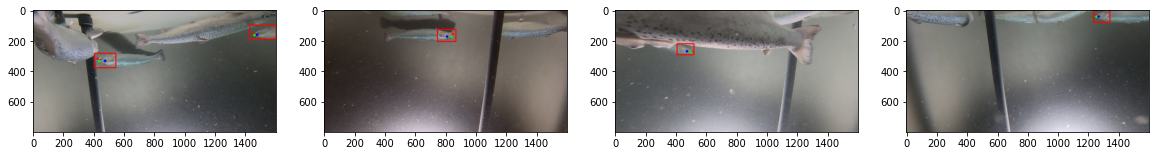

In [6]:
# visualize data from the data loader
import matplotlib.pyplot as plt
import cv2
import torchvision.transforms as T

def draw_label_on_img(images, targets, ax, batch_size = BATCH_SIZE,  iou_threshold = 0.1):
    toPilImg = T.ToPILImage()
    
    for idx, img in enumerate(images):
        # Transform image tensors to arrays
        img = torch.as_tensor(img.detach().cpu().numpy())
        img = np.array(toPilImg(img).convert('RGB'))
        # Perfroms NMS. Outpur is indices of bounding boxes. If no scores exists, all indices are returned.
        if 'scores' in targets[idx]:
            nms = torchvision.ops.nms(targets[idx]['boxes'], targets[idx]['scores'], iou_threshold = iou_threshold)
            nms = nms.detach().cpu().numpy()
        else:
            nms = list(range(len(targets[idx]['boxes'])))
        
        # Extraxt bounding box array from tensor
        boxes = targets[idx]['boxes'].detach().cpu().numpy()
        
        # Draw all valid bboxes and keypoints onto image
        for i in nms:
            cv2.rectangle(img, 
                tuple(boxes[i][:2].astype(int)),
                tuple(boxes[i][2:].astype(int)), 
                (255,0,0), 5)
            for keypoint in range(NUM_KEYPOINTS):
                color = (255,255,255)
                if keypoint == 0: color = (255,0,0) # ljaw
                if keypoint == 1: color = (0,255,0) # ujaw
                if keypoint == 2: color = (0,0,255) # eye
                cv2.circle(img, 
                           (int(targets[idx]['keypoints'][i][keypoint][0]), int(targets[idx]['keypoints'][i][keypoint][1])), 5,
                           color, 5)
            ax[idx].imshow(img) 
    return ax

# Call visualization function
fig, ax = plt.subplots(ncols=BATCH_SIZE, figsize=(20,20))
ax = draw_label_on_img(images, targets, ax)
plt.show()

In [7]:
# Define model

from torchvision.models.detection.rpn import AnchorGenerator
anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                               pretrained_backbone=True,
                                                               num_keypoints=3,
                                                               num_classes = 2)

In [8]:
# Review model
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()
images, targets = next(iter(data_loader))
print(model.roi_heads)

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=2, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
  )
  (keypoint_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(14, 14), sampling_ratio=2)
  (keypoint_head): KeypointRCNNHeads(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padd

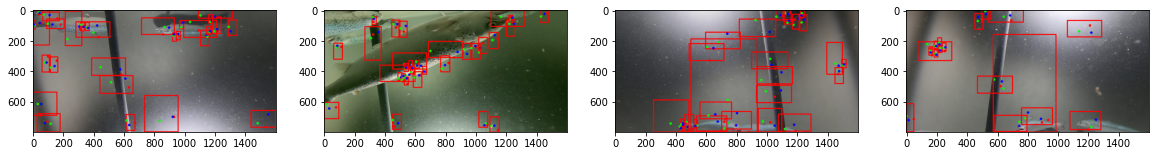

In [9]:
# Perform and plot untrained forward pass

# Untrained forward pass
images, targets = next(iter(data_loader))
model.to(device).eval()
output = model(images)

# Plot untrained forward pass
fig, ax = plt.subplots(ncols=BATCH_SIZE, figsize=(20,20))
ax = draw_label_on_img(images, output, ax)
plt.show()


In [10]:
# Import helper functions from pyvision

import sys
sys.path.insert(1, '../input/pytorch-vision/pytorch_vision')

from engine import train_one_epoch, evaluate

In [ ]:
# Train model

model.to(device).train()

# Choose trainable parameters, optimizer and learning rate
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=3,
                                            gamma=0.1)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    print("Start an epoch")
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    torch.save(model.state_dict(), 'salmon_keypoint_detection')

(tensor([[[0.2980, 0.2941, 0.2902,  ..., 0.2157, 0.2157, 0.2157],
         [0.2980, 0.2980, 0.2902,  ..., 0.2118, 0.2118, 0.2118],
         [0.3020, 0.2980, 0.2941,  ..., 0.2118, 0.2118, 0.2118],
         ...,
         [0.1451, 0.1451, 0.1451,  ..., 0.2902, 0.2863, 0.2824],
         [0.1451, 0.1451, 0.1451,  ..., 0.3843, 0.3804, 0.3765],
         [0.1490, 0.1490, 0.1490,  ..., 0.4745, 0.4745, 0.4706]],

        [[0.2941, 0.2902, 0.2863,  ..., 0.2196, 0.2196, 0.2196],
         [0.2941, 0.2941, 0.2863,  ..., 0.2157, 0.2157, 0.2157],
         [0.2980, 0.2941, 0.2902,  ..., 0.2157, 0.2157, 0.2157],
         ...,
         [0.1451, 0.1490, 0.1490,  ..., 0.2667, 0.2627, 0.2588],
         [0.1490, 0.1490, 0.1490,  ..., 0.3608, 0.3569, 0.3529],
         [0.1529, 0.1529, 0.1529,  ..., 0.4510, 0.4510, 0.4471]],

        [[0.2745, 0.2706, 0.2667,  ..., 0.2275, 0.2275, 0.2275],
         [0.2745, 0.2745, 0.2667,  ..., 0.2235, 0.2235, 0.2235],
         [0.2784, 0.2745, 0.2706,  ..., 0.2235, 0.2235, 0

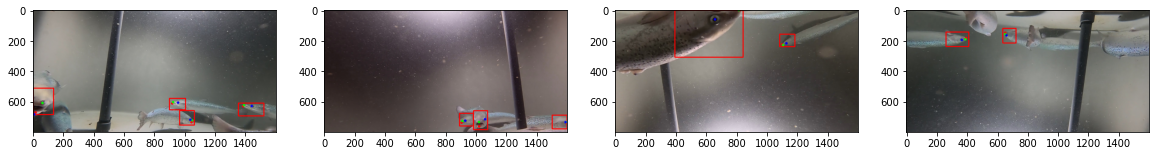

In [11]:
# Test model (after loading it into input as a dataset)

model.load_state_dict(torch.load('../input/salmon-keypoint-detection-10-epoch/salmon_keypoint_detection_10_epoch', map_location=device))
images, targets = next(iter(data_loader))

model.to(device).eval()
output = model(images)
print(images)
print(output)

fig, ax = plt.subplots(ncols=BATCH_SIZE, figsize=(20,20))
ax = draw_label_on_img(images, output, ax)
plt.show()